# 1.2: Bike Share II (Iteration)

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
#import sys
#sys.path.append('..\\..\\ModSimPy_Directory')
#from ModSimPy_Functions.modsim import flip

import pandas as pd
import numpy as np

def flip(p=0.5):
    """Flips a coin with the given probability.

    p: float 0-1

    returns: boolean (True or False)
    """
    return np.random.random() < p

It's something of a cliche in statistics and modeling to say, "All models are wrong, but some models are
more wrong than others." This chapter demonstrates the process we
use to make models less wrong.

As an example, we'll review the bikeshare model from the previous
chapter, consider its strengths and weaknesses, and gradually improve
it. We'll also see ways to use the model to understand the behavior of
the system and evaluate designs intended to make it work better.

## Iterative Modeling

The model we have so far is simple, but it is based on unrealistic
assumptions. Before you go on, take a minute to review the model from
the previous chapter. What assumptions is it based on? Make a list of
ways this model might be unrealistic; that is, what are the differences between the model and the real world?

Here are some of the differences on my list:

-   In the model, a student is equally likely to arrive during any
    one-minute period. In reality, this probability varies depending on time of day, day of the week, etc.

-   The model does not account for travel time from one bike station to another.

-   The model does not check whether a bike is available, so it's
    possible for the number of bikes to be negative (as you might have
    noticed in some of your simulations).

Some of these modeling decisions are better than others. For example,
the first assumption might be reasonable if we simulate the system for a short period of time, like one hour.

The second assumption is not very realistic, but it might not affect the results very much, depending on what we use the model for.

On the other hand, the third assumption seems problematic, and it is
relatively easy to fix. In this chapter, we will.

This process, starting with a simple model, identifying the most
important problems, and making gradual improvements, is called
*iterative modeling*.

For any physical system, there are many possible models, based on
different assumptions and simplifications. It often takes several
iterations to develop a model that is good enough for the intended
purpose, but no more complicated than necessary.

## More Than One State Object

Before we go on, I want to make a few changes to the code from the
previous chapter. First I'll generalize the functions we wrote so they
take a state `Series` object as a parameter. Then, I'll make the code more
readable by adding documentation.

Here is one of the functions from the previous chapter, `bike_to_moline`:

In [2]:
def bike_to_moline():
    bikeshare.augie -= 1
    bikeshare.moline += 1

When this function is called, it modifies `bikeshare`. As long as there
is only one state object, that's fine, but what if there is more than
one bike share system in the world? Or what if we want to run more than
one simulation?

This function would be more flexible if it took a `Series` object as a
parameter. Here's what that looks like:

In [3]:
def bike_to_moline(state):
    state.augie -= 1
    state.moline += 1

The name of the parameter is `state`, rather than `bikeshare`, as a
reminder that the value of `state` could be any state `Series` object, not just the one we called `bikeshare`.

This version of `bike_to_moline` requires a `Series` object as a
parameter, so we have to provide one when we call it:

In [4]:
bikeshare = pd.Series(dict(augie=10,moline=2),name="Number of Bikes")
bike_to_moline(bikeshare)

Again, the argument we provide gets assigned to the parameter, so this
function call has the same effect as:

```
state = bikeshare 
state.augie -= 1 
state.moline += 1
```

Now we can create as many `State` objects as we want:

In [5]:
bikeshare1 = pd.Series(dict(augie=10,moline=2),name="Number of Bikes")
bikeshare2 = pd.Series(dict(augie=2,moline=10),name="Number of Bikes")

And update them independently:

In [6]:
bike_to_moline(bikeshare1)
bike_to_moline(bikeshare2)
pd.DataFrame(bikeshare2)

,Number of Bikes
augie,1
moline,11


Changes in `bikeshare1` do not affect `bikeshare2`, and vice versa. So
we can simulate different bike share systems, or run multiple
simulations of the same system.

## Documentation

Another problem with the code we have so far is that it contains no
*documentation*.
Documentation is text we add to a program to help
other programmers read and understand it. It has no effect on the
program when it runs.

There are two kinds of documentation, *docstrings* and *comments*:

* A docstring is a string in triple quotes that appears at the beginning of a function.

* A comment is a line of text that begins with a hash symbol, `#`.

Here's a version of `bike_to_augie` with a docstring and a comment.

In [7]:
def bike_to_augie(state):
    """Move one bike from Moline to Augustana.
    
    state: bikeshare State object
    """
    # We decrease one state variable and increase the
    # other so the total number of bikes is unchanged.
    state.moline -= 1
    state.augie += 1

Docstrings follow a conventional format:

-   The first line is a single sentence that describes what the function does.

-   The following lines explain what the parameters are.

A function's docstring should include the information someone needs to
know to *use* the function; it should not include details about how the function works.

Comments provide details about how the function works, especially if there is something that would not be obvious to someone reading the program.

## Negative Bikes

The changes we've made so far improve the quality of the code, but we
haven't done anything to improve the quality of the model. Let's do that now.

Currently the simulation does not check whether a bike is available when a customer arrives, so the number of bikes at a location can be
negative. That's not very realistic.

Here's a version of `bike_to_augie` that fixes the problem:

In [8]:
def bike_to_augie(state):
    if state.moline == 0:
        return
    state.moline -= 1
    state.augie += 1

The first line checks whether the number of bikes at Moline is zero. If so, it uses a *return statement*, which causes the function to end immediately, without running the rest of the statements. So if there are no bikes at Moline, we return from `bike_to_augie` without changing the state.

We can test it by initializing a state with no bikes at Moline and calling `bike_to_augie`.

In [9]:
bikeshare = pd.Series(dict(augie=12,moline=0),name="Number of Bikes")
bike_to_augie(bikeshare)

The state of the system should be unchanged.

In [10]:
pd.DataFrame(bikeshare)

,Number of Bikes
augie,12
moline,0


No more negative bikes (at least at Moline).

## Comparison Operators

The updated version of `bike_to_augie` uses the equals operator, `==`, which compares two values and returns `True`, if they are equal, and `False` otherwise.

It is easy to confuse the equals operator with the assignment operator, `=`, which assigns a value to a variable. For example, the following statement creates a variable, `x`, if it doesn't already exist, and gives it the value `5`.

In [11]:
x = 5
x

5

On the other hand, the following statement checks whether `x` is `5` and
returns `True` or `False`. It does not create `x` or change its value.

In [12]:
x == 5

True

You can use the equals operator in an `if` statement, like this:

In [13]:
if x == 5:
    print('yes, x is 5')

yes, x is 5


If you make a mistake and use `=` in an `if` statement, like this:

```
if x = 5:
    print('yes, x is 5')
```

That's a *syntax error*, which means that the structure of the program is invalid. Python will print an error message and the program won't run.

The equals operator is one of Python's *comparison operators*. The others
are:

| Operation             	| Symbol 	|
|-----------------------	|--------	|
| Less than             	| `<`      	|
| Greater than          	| `>`      	|
| Less than or equal    	| `<=`     	|
| Greater than or equal 	| `>=`     	|
| Equal                 	| `==`     	|
| Not equal             	| `!=`     	|

## Metrics

Getting back to the bike share system, at this point we have the ability to simulate the behavior of the system. Since the arrival of customers is random, the state of the system is different each time we run a
simulation. Models like this are called random or *stochastic*; models
that do the same thing every time they run are *deterministic*.

Suppose we want to use our model to predict how well the bike share
system will work, or to design a system that works better. First, we
have to decide what we mean by "how well" and "better".

From the customer's point of view, we might like to know the probability of finding an available bike. From the system-owner's point of view, we might want to minimize the number of customers who don't get a bike when they want one, or maximize the number of bikes in use. Statistics like these that quantify how well the system works are called *metrics*.

As an example, let's measure the number of unhappy customers.
Here's a version of `bike_to_augie` that keeps track of the number of
customers who arrive at a station with no bikes:

In [14]:
def bike_to_augie(state):
    if state.moline == 0:
        state.moline_empty += 1
        return
    state.moline -= 1
    state.augie += 1

If a customer arrives at the Moline station and finds no bike
available, `bike_to_augie` updates `moline_empty`, which counts the
number of unhappy customers.

This function only works if we initialize `moline_empty` when we
create the state object, like this:

In [15]:
bikeshare = pd.Series(dict(augie=12,moline=0,moline_empty=0),name="Number of Bikes")

We can test it by calling `bike_to_augie`:

In [16]:
bike_to_augie(bikeshare)

After this update, there should be 12 bikes at Augustana, no bikes at Moline, and one unhappy customer.

In [17]:
pd.DataFrame(bikeshare)

,Number of Bikes
augie,12
moline,0
moline_empty,1


Looks good!

## Summary

In this chapter, we wrote several versions of `bike_to_augie`:

* We added a parameter, `state`, so we can work with more than one state object.

* We added a docstring that explains how to use the function and a comment that explains how it works.

* We used a conditional operator, `==`, to check whether a bike is available, in order to avoid negative bikes.

* We added a state variable, `moline_empty`, to count the number of unhappy customers, which is a metric we'll use to quantify how well the system works.

In the exercises, you'll update `bike_to_moline` the same way and test it by running a simulation.

## Exercises

Here's the code we have so far, with docstrings, all in one place.

In [18]:
def run_simulation(state,p1,p2,num_steps):
    """Simulate the given number of time steps.
    
    state: State object
    p1: probability of an Augustana->Wellesley customer arrival
    p2: probability of a Wellesley->Augustana customer arrival
    num_steps: number of time steps
    """
    results = pd.Series([],dtype=object)
    results.name = 'Number of Bikes at Augie'
    results.index.name = 'Time Step'
    results[0] = state.augie
    
    for i in range(num_steps):
        change_func(state,p1,p2)
        results[i+1] = state.augie
    results.plot(xlabel=results.index.name, ylabel=results.name,
            title='Augie-Moline Bikeshare',
            legend=True);

In [19]:
def change_func(state, p1, p2):
    """Simulate one time step.
    
    state: bikeshare State object
    p1: probability of an Augustana->Moline ride
    p2: probability of a Moline->Augustana ride
    """
    if flip(p1):
        bike_to_moline(state)
    
    if flip(p2):
        bike_to_augie(state)

In [20]:
def bike_to_augie(state):
    """Move one bike from Moline to Augustana.
    
    state: bikeshare State object
    """
    if state.moline == 0:
        state.moline_empty += 1
        return
    state.moline -= 1
    state.augie += 1

In [21]:
def bike_to_moline(state):
    """Move one bike from Augustana to Moline.
    
    state: bikeshare State object
    """
    state.augie -= 1
    state.moline += 1

### Exercise 1

 Modify `bike_to_moline` so it checks whether a bike is available at Augustana.  If not, it should add one to `augie_empty`.

To test it, create a `State` that initializes `augie` and `augie_empty` to `0`, run `bike_to_moline`, and check the result.

In [22]:
# Define new bike_to_moline
def bike_to_moline(state):
    """Move one bike from Augustana to Moline.
    
    state: bikeshare State object
    """
    if state.augie == 0:
        state.augie_empty += 1
        return
    state.moline += 1
    state.augie -= 1

In [23]:
# Test function
bikeshare = pd.Series(dict(augie=0,moline=12,augie_empty=0,moline_empty=0),name="Number of Bikes")
bike_to_moline(bikeshare)
pd.DataFrame(bikeshare)

,Number of Bikes
augie,0
moline,12
augie_empty,1
moline_empty,0


### Exercise 2

 Now run the simulation with parameters `p1=0.3`, `p2=0.2`, and `num_steps=60`, and confirm that the number of bikes is never negative.

Start with this initial state listed below.  You may need to use a higher value for num_steps to check the solution.

In [24]:
# This is the initial state
bikeshare = pd.Series(dict(augie=10,moline=2,augie_empty=0,
                           moline_empty=0),name="Number of Bikes")

,Number of Bikes
augie,11
moline,1
augie_empty,0
moline_empty,1


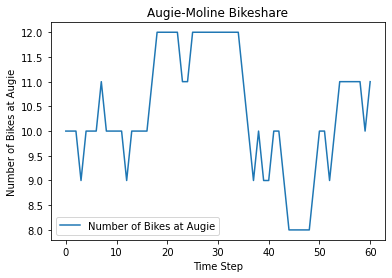

In [25]:
# Test run_simulation
run_simulation(bikeshare,0.3,0.2,60)
pd.DataFrame(bikeshare)

### Exercise 3

As another metric, we might be interested in the time until the first customer arrives and doesn't find a bike.  To make that work, we have to add a "clock" to keep track of how many time steps have elapsed:

1. Create a new state object with an additional state variable, `clock`, initialized to 0. 

2. Write a modified version of `change_func` that adds one to the clock each time it is invoked.

Test your code by running the simulation and check the value of `clock` at the end.

In [26]:
# Create a state object
bikeshare = pd.Series(dict(augie=10,moline=2,augie_empty=0,moline_empty=0,
                           clock=0),name="Number of Bikes")

In [27]:
# Write a modified version of "change_func"

def change_func(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Augustana->Moline customer arrival
    p2: probability of a Moline->Augustana customer arrival
    """
    state.clock += 1
    
    if flip(p1):
        bike_to_moline(state)
    
    if flip(p2):
        bike_to_augie(state)

,Number of Bikes
augie,12
moline,0
augie_empty,0
moline_empty,1
clock,60


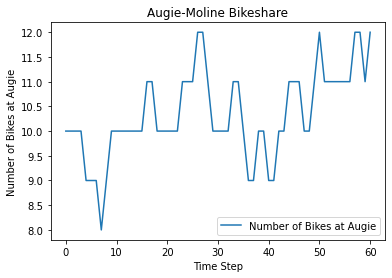

In [28]:
# Run the new simulation and print out bikeshare's variables

run_simulation(bikeshare, 0.4, 0.2, 60)
pd.DataFrame(bikeshare)

### Exercise 4

Continuing the previous exercise, let's record the time when the first customer arrives and doesn't find a bike.

1. Create a new state object with an additional state variable, `t_first_empty`, initialized to -1 as a special value to indicate that it has not been set. 

2. Write a modified version of `change_func` that checks whether`augie_empty` and `moline_empty` are 0.  If not, it should set `t_first_empty` to `clock` (but only if `t_first_empty` has not already been set).

Test your code by running the simulation and printing the values of augie_empty, moline_empty, and t_first_empty at the end.


In [29]:
# Create a state object 'bikeshare' but now with 6 parameters
bikeshare = pd.Series(dict(augie=10,moline=2,augie_empty=0,moline_empty=0,
                           clock=0,t_first_empty=-1),name="Number of Bikes")

In [30]:
# Rewrite 'change_func' as described

def change_func(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Augustana->Moline customer arrival
    p2: probability of a Moline->Augustana customer arrival
    """
    state.clock += 1
    
    if flip(p1):
        bike_to_moline(state)
    
    if flip(p2):
        bike_to_augie(state)
        
    if state.t_first_empty != -1:
        return
    
    if state.augie_empty + state.moline_empty > 0:
        state.t_first_empty = state.clock

augie             0
moline           12
augie_empty       5
moline_empty      0
clock            60
t_first_empty    34
Name: Number of Bikes, dtype: int64

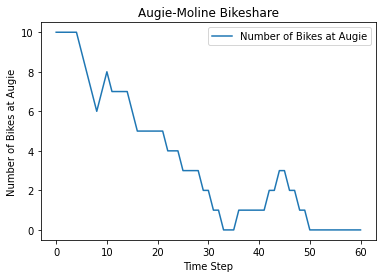

In [31]:
# Run the new simulation and print out bikeshare's variables
# Does the value for 't_first_empty' make sense with the plot?

run_simulation(bikeshare, 0.4, 0.2, 60)
bikeshare